In [1]:
!pip install -U textblob
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is alr

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import json
from collections import defaultdict 
from textblob import TextBlob
import re
import plotly.express as px

#############################################################################
# Step1 : data preprocessing


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r" v", " very", phrase)
    return phrase

reviewerID =[]
productID = []
reviewerName=[]
liked_and_seen = []
reviewText = []
rating = []
summary = []
unixTime = []
date = []

In [2]:
with open(r"C:\Users\kksan\Downloads\Cell_Phones_and_Accessories_5.json") as json_data:
    d = json.load(json_data)
    d = d[0:300]

for i in range(len(d)):
    reviewText.append(decontracted(d[i]['reviewText']))
    rating.append(d[i]['overall'])
    reviewerID.append(d[i]['reviewerID'])
    productID.append(d[i]['asin'])
#    reviewerName.append(d[i]['reviewerName'])
    liked_and_seen.append(d[i]['helpful'])
    summary.append(d[i]['summary'])
    unixTime.append(d[i]['unixReviewTime'])
    date.append(d[i]['reviewTime'])

In [3]:
# create  dataset
from pandas import DataFrame
dataset = DataFrame({'reviewerID': reviewerID, 'productID': productID, 'liked_and_seen': liked_and_seen, 'reviewText': reviewText, 'rating': rating, 'summary': summary, 'unixTime': unixTime, 'date': date})


In [4]:
#cleaning unwanted symbols
#cleaning unwanted symbols
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

comment_dict = defaultdict(list)
for i in range(len(dataset)):
    sentence = re.sub('[^a-zA-Z.]',' ',dataset['reviewText'][i])
    sentence = sentence.lower()
    sentence = sentence.split('.')
    for k in range(len(sentence)):
        review = sentence[k].split()
        review = [word for word in review if not word in set(stopwords.words('english'))]
        sentence[k] =  ' '.join(review)
        comment_dict[i].append(sentence[k])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kksan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#delete unwanted '' words
for j in range(len(comment_dict)):
    comment_dict[j] = [comment_dict[j][i] for i in range(len(comment_dict[j])) if comment_dict[j][i] not in '']

for i in range(len(comment_dict)):
    reviewText[i] = ('. '.join(comment_dict[i][j] for j in range(len(comment_dict[i]))))

In [6]:
# spelling correction
for i in range(len(reviewText)):
    b = TextBlob(reviewText[i])
    reviewText[i] = b.correct()
    
dataset_corrected= DataFrame({'reviewerID': reviewerID, 'productID': productID, 'liked_and_seen': liked_and_seen, 'reviewText': reviewText, 'rating': rating, 'summary': summary, 'unixTime': unixTime, 'date': date})

In [7]:
 
# creating corpus
corpus = defaultdict(set)
for i in range(len(reviewText)):
    wiki = reviewText[i]
    corpus[i] = wiki.sentences
            
corpus_key = corpus.keys()
corpus_list = defaultdict(list)

for i in corpus_key:
    for j in range(len(corpus[i])):
        word = ' '.join(corpus[i][j].words)
        corpus_list[i].append(word)

In [8]:
####################################################################################    
import numpy as np
# Step 2: adding biwords and triwords for generating patterns

length = defaultdict(list)
for i in corpus_key:
    length[i] = list(corpus_list[i])

# triwords       
for i in corpus_key:
    for j in range(len(length[i])):
        text = TextBlob(length[i][j])
        text = text.ngrams(n=3)
        for k in range(len(text)):
            triword = [' '.join([text[k][l] for l in range(len(text[k]))])]
            triword = triword[0]
            corpus_list[i].append(triword)
#biwords
for i in corpus_key:
    for j in range(len(length[i])):
        text = TextBlob(length[i][j])
        text = text.ngrams(n=2)
        for k in range(len(text)):
            triword = [' '.join([text[k][l] for l in range(len(text[k]))])]
            triword = triword[0]
            corpus_list[i].append(triword)

In [9]:
# corpus_list creates a list of all Opinion Words present in review text
# here the corpus contains sentences, biwords and triwords from review 
# Also here only matched text is used
####################################################################################    
# Step 3: Part-of-speech Tagging 

pos_dict = defaultdict(list)
for i in corpus_key:
    for j in range(len(corpus_list[i])):
        text = TextBlob(corpus_list[i][j])
        text = text.tags
        pos_dict[i].append(text)

pos_dict_key = pos_dict.keys()

corpus_noun = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        for k in range(len(pos_dict[i][j])):
            if(pos_dict[i][j][k][1] == 'NN'):
                corpus_noun[i].append(pos_dict[i][j][k])

In [10]:
pattern1 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 2:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            if first_pos == 'JJ' and second_pos in ['NN', 'NNS']:
                pattern1[i].append(pos_dict[i][j])


In [11]:
pattern2 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 3:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            third_pos = pos_dict[i][j][2][1]
            if first_pos == 'JJ' and (second_pos, third_pos) in [('NN', 'NN'), ('NN', 'NNS'), ('NNS', 'NN'), ('NNS', 'NNS')]:
                pattern2[i].append(pos_dict[i][j])


In [12]:
pattern3 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 2:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            if first_pos in ['RB', 'RBR', 'RBS'] and second_pos == 'JJ':
                pattern3[i].append(pos_dict[i][j])


In [13]:
pattern4 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 3:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            third_pos = pos_dict[i][j][2][1]
            
            if first_pos in ['RB', 'RBR', 'RBS'] and second_pos in ['RB', 'RBR', 'RBS', 'JJ'] and third_pos in ['NN', 'NNS']:
                pattern4[i].append(pos_dict[i][j])


In [14]:
pattern5 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 2:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            if first_pos in ['RB', 'RBR', 'RBS'] and second_pos in ['VBN', 'VBD']:
                pattern5[i].append(pos_dict[i][j])


In [15]:
pattern6 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 3:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            third_pos = pos_dict[i][j][2][1]
            
            if first_pos in ['RB', 'RBR', 'RBS'] and second_pos in ['RB', 'RBR', 'RBS'] and third_pos == 'JJ':
                pattern6[i].append(pos_dict[i][j])


In [16]:
pattern7 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 2:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            if first_pos in ['VBN', 'VBD'] and second_pos in ['NN', 'NNS']:
                pattern7[i].append(pos_dict[i][j])


In [17]:
pattern8 = defaultdict(list)
for i in pos_dict_key:
    for j in range(len(pos_dict[i])):
        if len(pos_dict[i][j]) == 2:
            first_pos = pos_dict[i][j][0][1]
            second_pos = pos_dict[i][j][1][1]
            if (first_pos in ['VBN', 'VBD']) and (second_pos in ['RB', 'RBR', 'RBS']):
                pattern8[i].append(pos_dict[i][j])


In [18]:
pattern = defaultdict(set)
pattern.update(pattern1)
pattern.update(pattern2)
pattern.update(pattern3)
pattern.update(pattern4)
pattern.update(pattern5)
pattern.update(pattern6)
pattern.update(pattern7)
pattern.update(pattern8)

In [19]:
#select stuff from OT_OW_key
####################################################################################
# Step 5: Semi- supervised approach creates Opinion Target from stuff.

stuff = ['software', 'application', 'service', 'power supply', 'sim card', 'display', 
         'storage space', 'sensor', 'wireless charging', 'design', 'cpu', 'accessories',
         'camera','quality','time','condition','screen','price','case','build','access',
         'battery','buy','power','switch','light','design','technology','radio','fashion'
'product','charging','feature','touch','profile','car','slot','tables','construction',
'period ','system','game','bottom','sound','blackberry charge','price anyone','price extra',
'cord length','charge port',' phone','horizon charge','fraction price','charge ','key',
'extension','internet','cheap','cover','speaker']

In [20]:
####################################################################################
# Step 6: Finding Similar waords of above Opinion Targets

from nltk.corpus import wordnet as wn
from itertools import chain

In [21]:
stuff_OT = defaultdict(set)
OT2 = set()

synsets_set = defaultdict(set)
hyponyms_set = defaultdict(set)

In [22]:
for z in range(len(stuff)): 
    input_word = stuff[z] 
    OT1= set()    
    for i,j in enumerate(wn.synsets(input_word)):
    #    print ('Meaning', i, 'NLTK ID: ', j.name())
        
        hypernyms = ', '.join(list(chain(*[l.lemma_names() for l in j.hypernyms()])))
    #    print ('Hypernyms:', hypernyms)
        synsets_set[i].add(hypernyms)
        
        hyponyms = ', '.join(list(chain(*[l.lemma_names() for l in j.hyponyms()])))
    #    print ('Hyponyms:', hyponyms)
        hyponyms_set[i].add(hyponyms)
    #    print() 

        ho = [hypernyms]
        for h in range(len(ho)):
            temp_list = ho[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OT2.add(temp_word)
                    OT1.add(temp_word)
        
        hy = [hypernyms]
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OT2.add(temp_word)
                    OT1.add(temp_word)
    OT1 = list(OT1)
    for i in range(len(OT1)):
        stuff_OT[stuff[z]].add(OT1[i])

In [23]:
# stuff contains Opinion Target and its similar words from wordnet        
####################################################################################

hyponyms_set_keys = hyponyms_set.keys()
synsets_set_keys = synsets_set.keys()

In [24]:
for z in range(len(stuff)):  
    
    for k in hyponyms_set_keys:
        hy = hyponyms_set[k]
        hy = list(hy)
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OT2.add(temp_word)

In [25]:
for z in range(len(stuff)):    
    for k in synsets_set_keys:
        hy = synsets_set[k]
        hy = list(hy)
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OT2.add(temp_word)

In [26]:
OT2 = list(OT2)
list_of_subset = defaultdict(set)

In [27]:
for i in range(len(stuff)):
    stuff_OT[stuff[i]] = list(stuff_OT[stuff[i]])
    for j in range(len(stuff_OT[stuff[i]])):
        list_of_subset[i].add(stuff[i])
        list_of_subset[i].add(stuff_OT[stuff[i]][j])

In [28]:
for i in list_of_subset.keys():
    list_of_subset[i] = list(list_of_subset[i])

In [29]:
list_of_subset2 =[]
for i in range(len(stuff)):
    list_of_subset2.append(stuff[i])

for i in list_of_subset.keys():
    for j in range(len(list_of_subset[i])):
        list_of_subset2.append(list_of_subset[i][j])

stuff = list_of_subset2

In [30]:
#######################################################################################
# Step 7: Finding Opinion Words of above Opinion Target(Stuff + its similar words.)
#         from pattern generated in step 3.

OW = defaultdict(set)
OT = defaultdict(set)
OT_OW = defaultdict(set)
OW_OT = defaultdict(set)

In [31]:
# it has 1 OW
pattern1_OT_OW =  defaultdict(set)
pattern1_OW_OT =  defaultdict(set)
p1_keys = pattern1.keys()
for i in p1_keys:
    if( pattern1[i] != []):
        for j in range(len(pattern1[i])):
            OT[i].add(pattern1[i][j][1][0])
            OW[i].add(pattern1[i][j][0][0])
            if(pattern1[i][j][1][0] in stuff):
                OT_OW[pattern1[i][j][1][0]].add(pattern1[i][j][0][0])
                OW_OT[pattern1[i][j][0][0]].add(pattern1[i][j][1][0])
                
                pattern1_OT_OW[pattern1[i][j][1][0]].add(pattern1[i][j][0][0])
                pattern1_OW_OT[pattern1[i][j][0][0]].add(pattern1[i][j][1][0])

In [32]:
#it has 1 OW             
pattern2_OT_OW = defaultdict(set)
pattern2_OW_OT = defaultdict(set)
p2_keys = pattern2.keys()
for i in p2_keys:
    if( pattern2[i] != []):
        for j in range(len(pattern2[i])):    
            target = pattern2[i][j][1][0] + " " + pattern2[i][j][2][0]
            OT[i].add(target)
            OW[i].add(pattern2[i][j][0][0])
            if(pattern2[i][j][1][0] in stuff or pattern2[i][j][2][0] in stuff or target in stuff):
                OT_OW[target].add(pattern2[i][j][0][0])
                OW_OT[pattern2[i][j][0][0]].add(target)
            
                pattern2_OT_OW[target].add(pattern2[i][j][0][0])
                pattern2_OW_OT[pattern2[i][j][0][0]].add(target)

In [33]:
# dont filter here
# it has 2 OW pretty, good we use only pretty good combination
pattern3_OW_OT = defaultdict(set)       
p3_keys = pattern3.keys()
for i in p3_keys:
    if( pattern3[i] != []):
        for j in range(len(pattern3[i])):    
            target = pattern3[i][j][0][0] + " " + pattern3[i][j][1][0]
            OW[i].add(target)

            OW_OT[target].add('NO Opinion Target found')
            
            pattern3_OW_OT[target].add('NO Opinion Target found')

In [34]:
# we use near much, near, much word combinations in OW here
pattern4_OT_OW = defaultdict(set)         
pattern4_OW_OT = defaultdict(set)  
p4_keys = pattern4.keys()
for i in p4_keys:
    if( pattern4[i] != []):
        for j in range(len(pattern4[i])):    
            word = pattern4[i][j][0][0] + " " + pattern4[i][j][1][0] 
            OT[i].add(pattern4[i][j][2][0])
            OW[i].add(word)
            if(pattern4[i][j][2][0] in stuff):
                OT_OW[pattern4[i][j][2][0]].add(word)
                
                OW_OT[word].add(pattern4[i][j][2][0])
                
                pattern4_OT_OW[pattern4[i][j][2][0]].add(word)
                
                pattern4_OW_OT[word].add(pattern4[i][j][2][0])

In [35]:
# dont filter here            
pattern5_OW_OT = defaultdict(set)           
p5_keys = pattern5.keys()
for i in p5_keys:
    if( pattern5[i] != []):
        for j in range(len(pattern5[i])):    
            target = pattern5[i][j][0][0] + ' ' + pattern5[i][j][1][0]
            OW[i].add(target)
            OW_OT[target].add('No Opinion Target found')
            
            pattern5_OW_OT[target].add('No Opinion Target found')

In [36]:
# dont filter here
pattern6_OW_OT = defaultdict(set)
p6_keys = pattern6.keys()
for i in p6_keys:
    if( pattern6[i] != []):
        for j in range(len(pattern6[i])):    
            target = pattern6[i][j][0][0] + " " + pattern6[i][j][2][0]
            OW[i].add(target)
            OW_OT[target].add('NO Opinion Target found')
            
            pattern6_OW_OT[target].add('NO Opinion Target found')

In [37]:
pattern7_OW_OT = defaultdict(set)
pattern7_OT_OW = defaultdict(set)
p7_keys = pattern7.keys()
for i in p7_keys:
    if( pattern7[i] != []):
        for j in range(len(pattern7[i])):    
            target = pattern7[i][j][1][0]
            OT[i].add(target)
            OW[i].add(pattern7[i][j][0][0])
            
            if(target in stuff):
                OW_OT[pattern7[i][j][0][0]].add(target)
                OT_OW[target].add(pattern7[i][j][0][0])
                
                pattern7_OW_OT[pattern7[i][j][0][0]].add(target)
                pattern7_OT_OW[target].add(pattern7[i][j][0][0])

In [38]:
# dont filter here
pattern_8_OW_OT = defaultdict(set)
p8_keys = pattern8.keys()
for i in p8_keys:
    if( pattern8[i] != []):
        for j in range(len(pattern8[i])):    
            target = pattern8[i][j][1][0]
            
            OW[i].add(target)
            OW_OT[target].add('No Opinion Target found')
            pattern_8_OW_OT[target].add('No Opinion Target found')

In [39]:
################################################################################            
# Step 8: Finding similar Words of above Opinion Words.
            
OW_OT_key = OW_OT.keys()
OW_list = list(OW_OT_key)

In [40]:
from nltk.corpus import wordnet as wn
from itertools import chain

stuff_OW = defaultdict(set)
OW2 = set()

synsets_set = defaultdict(set)
hyponyms_set = defaultdict(set)

In [41]:
for z in range(len(OW_list)): 
    input_word = OW_list[z] 
    OW1= set()    
    for i,j in enumerate(wn.synsets(input_word)):
    #    print ('Meaning', i, 'NLTK ID: ', j.name())
        
        hypernyms = ', '.join(list(chain(*[l.lemma_names() for l in j.hypernyms()])))
    #    print ('Hypernyms:', hypernyms)
        synsets_set[i].add(hypernyms)
        
        hyponyms = ', '.join(list(chain(*[l.lemma_names() for l in j.hyponyms()])))
    #    print ('Hyponyms:', hyponyms)
        hyponyms_set[i].add(hyponyms)
    #    print() 

        ho = [hypernyms]
        for h in range(len(ho)):
            temp_list = ho[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OW2.add(temp_word)
                    OW1.add(temp_word)
        
        hy = [hypernyms]
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OW2.add(temp_word)
                    OW1.add(temp_word)
    OW1 = list(OW1)
    for i in range(len(OW1)):
        stuff_OW[OW_list[z]].add(OW1[i])

In [42]:
hyponyms_set_keys = hyponyms_set.keys()
synsets_set_keys = synsets_set.keys()

In [43]:
for z in range(len(OW_list)):    
    for k in hyponyms_set_keys:
        hy = hyponyms_set[k]
        hy = list(hy)
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OW2.add(temp_word)

In [44]:
for z in range(len(OW_list)):    
    for k in synsets_set_keys:
        hy = synsets_set[k]
        hy = list(hy)
        for h in range(len(hy)):
            temp_list = hy[h].split(', ')
            if(temp_list != ['']):
                for l in range(len(temp_list)):
                    temp_word = ' '.join(temp_list[l].split('_'))
                    OW2.add(temp_word)
                    

In [45]:
OW_concept = []
OW2 = list(OW2)

In [46]:
for i in range(len(OW2)):
    if(OW2[i] != ''):
        OW_concept.append(OW2[i])
        
for i in range(len(OW_list)):
    OW_concept.append(OW_list[i])

In [47]:
# Here OW_concept creates a list of all similar Opinion words of Opinion words generated from pattern
#####################################################################################
# Step 9: Finding Opinion Weight of above similar Opinion Words ( from testimonial.sentiment.polarity )

OW_OT = OW_concept                   
OW_OT_key = OW_OT
OT_OW_key = OT_OW.keys()

OW_in_corpus = defaultdict(set)

In [48]:
for i in corpus.keys():
    for j in range(len(corpus[i])):
        word = corpus[i][j].words
        for k in range(len(word)):
            if( word[k] in OW_OT_key):
              OW_in_corpus[i].add(word[k])

In [49]:
for i in OW_in_corpus.keys():
    OW_in_corpus[i] = list(OW_in_corpus[i]) 

In [50]:
testimonial_sentiment = defaultdict(list)
testimonial_sentiment_polarity = defaultdict(list)


In [51]:
for i in OW_in_corpus.keys():
    for j in range(len(OW_in_corpus[i])):
        testimonial = TextBlob(OW_in_corpus[i][j])
        testimonial_sentiment[OW_in_corpus[i][j]].append(testimonial.sentiment)
        testimonial_sentiment_polarity[OW_in_corpus[i][j]].append(testimonial.sentiment.polarity)

In [52]:
OW_in_corpus_list = defaultdict(list)
OW_in_corpus_value = defaultdict(list)

In [53]:
for i in OW_in_corpus.keys():
    for j in range(len(OW_in_corpus[i])):
        word = [OW_in_corpus[i][j]]
#        for k in range(len(word)):
        if(word[0] in testimonial_sentiment_polarity.keys()):
            polarity = testimonial_sentiment_polarity[word[0]]
            OW_in_corpus_value[i].append(polarity[0])
            OW_in_corpus_list[i].append(word[0])

In [54]:
dictionary1 = dict()
dictionary2 = dict()
key_value_pair = defaultdict(list)

In [55]:
for i in range(len(OW_in_corpus_list)):
    for j in range(len(OW_in_corpus_list[i])):
#        dictionary1[OW_in_corpus_value[i][j]] = OW_in_corpus_list[i][j]
        dictionary2[ OW_in_corpus_list[i][j]] = OW_in_corpus_value[i][j]  

In [56]:
################################################################################################
# Step 10: Creating Words and its score in tuple_word_score                

score = defaultdict(list)
words = OW_in_corpus_list
OW_in_corpus_value_key = OW_in_corpus_value.keys()
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        score[i].append(OW_in_corpus_value[i][j])
                
tuple_word_score = defaultdict(list)
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        tuple_word_score[i].append((words[i][j], score[i][j]))
        
Opinion_Words = tuple_word_score

list_Opinion_Words = []
for i in range(len(Opinion_Words)):
    list_Opinion_Words.append(Opinion_Words[i])

In [57]:
################################################################################################
# Step 11: Finding Maximum scored words.                

max_abs_score = defaultdict(list)
for i in range(len(tuple_word_score)):
    maxx = 0
    for j in range(len(tuple_word_score[i])):
        temp = abs(tuple_word_score[i][j][1])
        if(temp > maxx):
            maxx = abs(tuple_word_score[i][j][1])
            maxx_word = tuple_word_score[i][j][0]
    max_abs_score[i].append((maxx_word, maxx))

In [58]:
##################################################

maxx_OW_value = defaultdict(set)
for i in range(len(max_abs_score)):
    maxx_OW_value[max_abs_score[i][0][0]].add(max_abs_score[i][0][1])
    
New_OW = maxx_OW_value.keys()

In [59]:
################################################
# step11: Collecting important opinion words.

list_max_abs_score = []
for i in range(len(max_abs_score)):
    list_max_abs_score.append(max_abs_score[i])

In [60]:
##########Searching######################################
# step12: Searching it again

OW_in_corpus2 = defaultdict(set)
for i in range(len(corpus)):
    for j in range(len(corpus[i])):
        word = corpus[i][j].words
        for k in range(len(word)):
            if( word[k] in New_OW):
              OW_in_corpus2[i].add(word[k])

In [61]:
for i in OW_in_corpus2.keys():
    OW_in_corpus2[i] = list(OW_in_corpus2[i]) 

In [62]:
             
testimonial_sentiment = defaultdict(list)
testimonial_sentiment_polarity = defaultdict(list)


In [63]:
for i in OW_in_corpus2.keys():
    for j in range(len(OW_in_corpus2[i])):
        testimonial = TextBlob(OW_in_corpus2[i][j])
        testimonial_sentiment[OW_in_corpus2[i][j]].append(testimonial.sentiment)
        testimonial_sentiment_polarity[OW_in_corpus2[i][j]].append(testimonial.sentiment.polarity)


In [64]:
OW_in_corpus_list = defaultdict(list)
OW_in_corpus_value = defaultdict(list)

In [65]:
for i in OW_in_corpus2.keys():
    for j in range(len(OW_in_corpus2[i])):
        word = [OW_in_corpus2[i][j]]
#        for k in range(len(word)):
        if(word[0] in testimonial_sentiment_polarity.keys()):
            polarity = testimonial_sentiment_polarity[word[0]]
            OW_in_corpus_value[i].append(polarity[0])
            OW_in_corpus_list[i].append(word[0])


In [66]:
dictionary1 = dict()
dictionary2 = dict()
key_value_pair = defaultdict(list)

In [67]:
for i in range(len(OW_in_corpus_list)):
    for j in range(len(OW_in_corpus_list[i])):
#        dictionary1[OW_in_corpus_value[i][j]] = OW_in_corpus_list[i][j]
        dictionary2[ OW_in_corpus_list[i][j]] = OW_in_corpus_value[i][j]  


In [68]:
# OW_in_corpus_value indicates the polarity score of opinion word
###############################################################################
import numpy as np
              
score = defaultdict(list)
words = OW_in_corpus_list
OW_in_corpus_value_key = OW_in_corpus_value.keys()
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        score[i].append(OW_in_corpus_value[i][j])

In [69]:
tuple_word_score = defaultdict(list)
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        tuple_word_score[i].append((words[i][j], score[i][j]))

In [70]:
##########################################################################


final_score = defaultdict(list)
for i in range(len(tuple_word_score)):
    final_score[i].append(0)
    
for i in range(len(tuple_word_score)):
    for j in range(len(tuple_word_score[i])):
        final_score[i].append(tuple_word_score[i][j][1])
        
final_score = defaultdict(list)

In [71]:
for i in range(len(tuple_word_score)):
    final_score[i].append(0)
    
for i in range(len(tuple_word_score)):
    for j in range(len(tuple_word_score[i])):
        final_score[i].append(tuple_word_score[i][j][1])

In [72]:
############################################################################################
#Step 13: Creating Average
average_score = defaultdict(list)
for i in range(len(final_score)):
    average_score[i].append(np.mean(final_score[i]))


for i in range(len(average_score)):
    if(np.isnan(average_score[i]) == True):
        average_score[i] = [0]

list_average_score = []
for i in range(len(average_score)):
    list_average_score.append(average_score[i])

In [73]:
############################################################################################
    
import numpy as np
  
X_train = []   
for i in average_score.keys():
    temp = set()
    for j in range(len(OW_in_corpus[i])):
        temp.add(OW_in_corpus[i][j])
    X_train.append(temp)
    
l = set()
for i in range(len(X_train)):
    X_train[i] = list (X_train[i])
    for j in range(len(X_train[i])):
        l.add(X_train[i][j])

l =list(l)

In [74]:
import pandas as pd
da = pd.DataFrame(columns = l, index = OW_in_corpus.keys(), data = 0)

k = list(OW_in_corpus.keys())

for m in range(len(k)):
    for j in range(len(l)):
        if(l[j] in OW_in_corpus[k[m]]):
            da.iloc[m][l[j]] = 1

X_train = da.iloc[:, 0:]
X_train = np.array(X_train)

y_train = []
for i in average_score.keys():
    y_train.append(average_score[i][0])    

r = (max(y_train) - min(y_train)) / 4
m = min(y_train)

y_train = np.array(y_train)

y = []
for i in range(len(y_train)):
    y.append(y_train[i])

X = X_train

C:\Users\kksan\AppData\Local\Temp\ipykernel_13732\879726198.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  da.iloc[m][l[j]] = 1


In [75]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [76]:
for i in range(len(y)):
    if(y[i] <= m):
        y[i] = 'Negative'
    elif(y[i] <= m+r and y[i] > m):
        y[i] = 'Negative'
    elif(y[i] <= m+r+r and y[i] > m+r):
        y[i] = 'Negative'
    elif(y[i] <= m+r+r+r and y[i] > m+r+r):
        y[i] = 'Positive'
    elif(y[i] <= m+r+r+r+r and y[i] > m+r+r+r):
        y[i] = 'Positive'
        
y_set = defaultdict(list)

In [77]:
y_set

defaultdict(list, {})

In [78]:
key = average_score.keys()
key = list(key)


In [79]:
for i in range(len(key)):
    y_set[key[i]].append(y[i])


In [80]:
da['calculated rating'] = [y_set[i] for i in y_set.keys()]

In [81]:
rev_rate = []
rate = dataset['rating']

In [82]:
for i in y_set.keys():
    rev_rate.append(rate[i])

In [83]:
for i in range(len(rev_rate)):
    if(rev_rate[i] == 1.0):
        rev_rate[i] = 'Negative'
    elif(rev_rate[i] == 2.0):
        rev_rate[i] = 'Negative'
    elif(rev_rate[i] == 3.0):
        rev_rate[i] = 'Negative'
    elif(rev_rate[i] == 4.0):
        rev_rate[i] = 'Positive'
    elif(rev_rate[i] == 5.0):
        rev_rate[i] = 'Positive'

In [84]:
list_tuple_word_score = []
for i in range(len(tuple_word_score)):
    list_tuple_word_score.append(tuple_word_score[i])

In [85]:
comparision_dataframe = pd.DataFrame()

In [86]:
comparision_dataframe['Original Review'] = dataset['reviewText']
comparision_dataframe['Opinion Words'] = list_Opinion_Words
comparision_dataframe['Maximum scored Opinion Words'] = list_max_abs_score
comparision_dataframe['Final Opnion Words'] = list_tuple_word_score
comparision_dataframe['Average'] = list_average_score
comparision_dataframe['Reviewer Rating'] = rev_rate
comparision_dataframe['Calculated rating'] = y

In [87]:
save = comparision_dataframe.to_csv(sep=',')
text_file = open("train_file.csv", "w")
text_file.write(save)
text_file.close()

In [88]:
#######################################################################
# Step 14:  Making the Confusion Matrix

y = comparision_dataframe['Calculated rating']

from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(rev_rate, y)

accuracy = 0

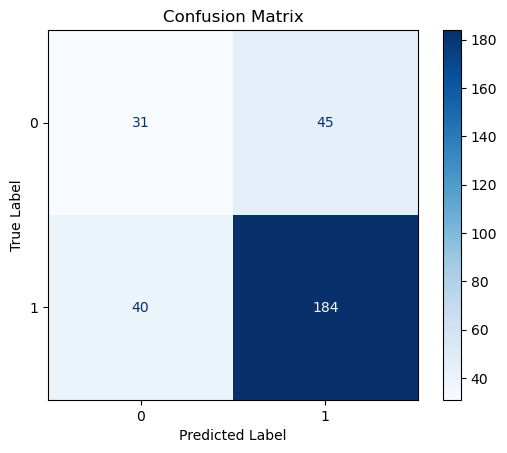

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plotting the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [90]:
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy = accuracy/ len(rev_rate) * 100

In [91]:
accuracy

71.66666666666667

In [92]:
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

In [93]:
num_classes = len(cm)
TN = []

In [94]:
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))

In [95]:
    
#Let's make a sanity check: for each class, the sum of TP, FP, FN, and TN 
# must be equal to the size of our test set (here 10,000): 
#let's confirm that this is indeed the case:
    
l = len(rev_rate)
for i in range(num_classes):
    print(TP[i] + FP[i] + FN[i] + TN[i] == l)

True
True


In [96]:
# link : http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

precision = TP/(TP+FP)
recall = TP/(TP+FN)
FScore = 2*(recall * precision) / (recall + precision)

DataFrame = pd.DataFrame()
DataFrame['precision'] = precision
DataFrame['recall'] = recall
DataFrame['FScore'] = FScore

In [97]:
print(DataFrame['precision'])
print(DataFrame['recall'])
print(DataFrame['FScore'])

0    0.436620
1    0.803493
Name: precision, dtype: float64
0    0.407895
1    0.821429
Name: recall, dtype: float64
0    0.421769
1    0.812362
Name: FScore, dtype: float64


In [98]:
print('\nDataFrame:\n', DataFrame)
print('\n\nConfusion Matrix:\n', cm)
print('\n\nAccuracy: ', accuracy)


DataFrame:
    precision    recall    FScore
0   0.436620  0.407895  0.421769
1   0.803493  0.821429  0.812362


Confusion Matrix:
 [[ 31  45]
 [ 40 184]]


Accuracy:  71.66666666666667


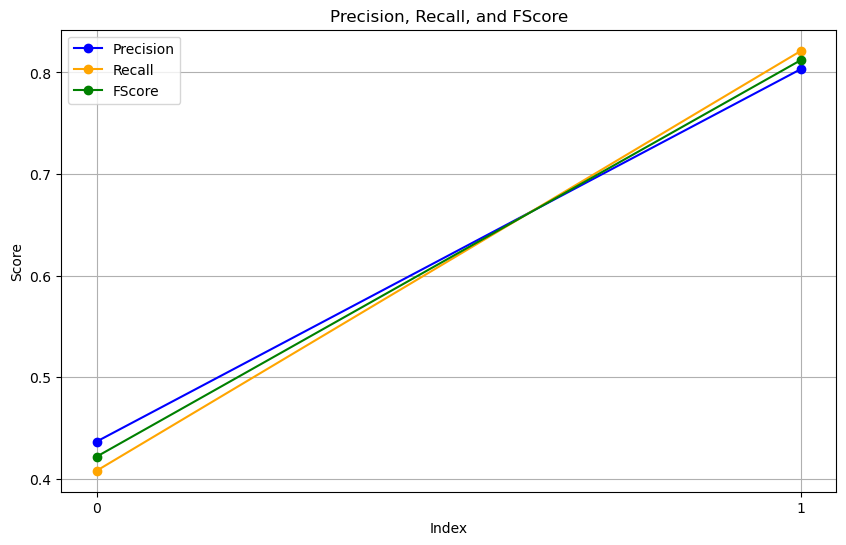

In [99]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting each metric
plt.plot(DataFrame['precision'], marker='o', label='Precision', color='blue')
plt.plot(DataFrame['recall'], marker='o', label='Recall', color='orange')
plt.plot(DataFrame['FScore'], marker='o', label='FScore', color='green')

# Adding titles and labels
plt.title('Precision, Recall, and FScore')
plt.xlabel('Index')
plt.ylabel('Score')
plt.xticks(range(len(DataFrame)))  # Set x-ticks to match the DataFrame index
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [100]:
###################################################################################################
#################################################################################################3
# Step 15: Testing

New_sentence = "this phone is gifted to me by my friend.oh my god!!. i am not much impreseed by the sound quality. It isn't the one i expected. i am disappointed by its short term life."
New_rating = 'Negative'
New_sentence = ' This is a wonderful screen touch!! can it get better than this? i am so much excited!!'
New_rating = 'Positive'

In [101]:
#step 1: pre processing

# isn't = is not
New_sentence = decontracted(New_sentence)


In [102]:
New_sentence

' This is a wonderful screen touch!! can it get better than this? i am so much excited!!'

In [103]:

# removed Unwanted symbols, lower case
comment_dict2 = defaultdict(list)
for i in range(1):
    sentence = re.sub('[^a-zA-Z.]',' ', New_sentence)
    sentence = sentence.lower()
    sentence = sentence.split('.')
    for k in range(len(sentence)):
        review = sentence[k].split()
        review = [word for word in review if not word in set(stopwords.words('english'))]
        sentence[k] =  ' '.join(review)
        comment_dict2[i].append(sentence[k])

In [104]:
comment_dict2

defaultdict(list, {0: ['wonderful screen touch get better much excited']})

In [105]:
#delete unwanted '' words
for j in range(len(comment_dict2)):
    comment_dict2[j] = [comment_dict2[j][i] for i in range(len(comment_dict2[j])) if comment_dict2[j][i] not in '']

Text = defaultdict(list)
for i in range(len(comment_dict2)):
    Text[i].append(('. '.join(comment_dict2[i][j] for j in range(len(comment_dict2[i])))))


In [106]:
Text

defaultdict(list, {0: ['wonderful screen touch get better much excited']})

In [107]:
# spelling correction
for i in range(len(Text)):
    b = TextBlob(Text[i][0])
    Text[i] = b.correct()


In [108]:
# creating corpus
corpus2 = defaultdict(set)
for i in range(len(Text)):
    wiki = Text[i]
    corpus2[i] = wiki.sentences
            
corpus_key2 = corpus2.keys()
corpus_list2 = defaultdict(list)

for i in corpus_key2:
    for j in range(len(corpus2[i])):
        word = ' '.join(corpus2[i][j].words)
        corpus_list2[i].append(word)

Text = ""
for i in range(len(corpus_list2)):
    temp = corpus_list2[i]
    for j in temp:
        Text += str(j) + ' '

In [109]:
Text

'wonderful screen touch get better much excited '

In [110]:
##########################################################################
# Step2 of testing : Use OW and find its score
        
list_max_abs_score = []
for i in range(len(max_abs_score)):
    list_max_abs_score.append(max_abs_score[i])

t = TextBlob(Text)
OW_in_corpus22 = defaultdict(set)

In [111]:
for i in range(len(corpus2)):
    for j in range(len(corpus2[i])):
        word = t.words
        for k in range(len(word)):
            if( word[k] in New_OW):
              OW_in_corpus22[i].add(word[k])

In [112]:
for i in OW_in_corpus22.keys():
    OW_in_corpus22[i] = list(OW_in_corpus22[i])            
              
testimonial_sentiment = defaultdict(list)
testimonial_sentiment_polarity = defaultdict(list)
OW_in_corpus2 = OW_in_corpus22

In [113]:
for i in OW_in_corpus2.keys():
    for j in range(len(OW_in_corpus2[i])):
        testimonial = TextBlob(OW_in_corpus2[i][j])
        testimonial_sentiment[OW_in_corpus2[i][j]].append(testimonial.sentiment)
        testimonial_sentiment_polarity[OW_in_corpus2[i][j]].append(testimonial.sentiment.polarity)

OW_in_corpus_list = defaultdict(list)
OW_in_corpus_value = defaultdict(list)

In [114]:
for i in OW_in_corpus2.keys():
    for j in range(len(OW_in_corpus2[i])):
        word = [OW_in_corpus2[i][j]]
#        for k in range(len(word)):
        if(word[0] in testimonial_sentiment_polarity.keys()):
            polarity = testimonial_sentiment_polarity[word[0]]
            OW_in_corpus_value[i].append(polarity[0])
            OW_in_corpus_list[i].append(word[0])

dictionary1 = dict()
dictionary2 = dict()

In [115]:
key_value_pair = defaultdict(list)
for i in range(len(OW_in_corpus_list)):
    for j in range(len(OW_in_corpus_list[i])):
#        dictionary1[OW_in_corpus_value[i][j]] = OW_in_corpus_list[i][j]
        dictionary2[ OW_in_corpus_list[i][j]] = OW_in_corpus_value[i][j]  


In [116]:
print(key_value_pair)

defaultdict(<class 'list'>, {})


In [117]:
import numpy as np            
score = defaultdict(list)
words = OW_in_corpus_list
OW_in_corpus_value_key = OW_in_corpus_value.keys()
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        score[i].append(OW_in_corpus_value[i][j])
       
tuple_word_score = defaultdict(list)

In [118]:
print(tuple_word_score)

defaultdict(<class 'list'>, {})


In [119]:
for i in OW_in_corpus_value_key:
    for j in range(len(OW_in_corpus_value[i])):
        tuple_word_score[i].append((words[i][j], score[i][j]))

final_score = defaultdict(list)

In [120]:
final_score

defaultdict(list, {})

In [121]:
for i in range(len(tuple_word_score)):
    final_score[i].append(0)

In [122]:
for i in range(len(tuple_word_score)):
    for j in range(len(tuple_word_score[i])):
        final_score[i].append(tuple_word_score[i][j][1])

In [123]:
final_score = defaultdict(list)
for i in range(len(tuple_word_score)):
    final_score[i].append(0)
    

In [124]:
for i in range(len(tuple_word_score)):
    for j in range(len(tuple_word_score[i])):
        final_score[i].append(tuple_word_score[i][j][1])

average_score = defaultdict(list)

In [125]:
for i in range(len(final_score)):
    average_score[i].append(np.mean(final_score[i]))


In [126]:
for i in range(len(average_score)):
    if(np.isnan(average_score[i]) == True):
        average_score[i] = [0]

list_avg = []

In [127]:
for i in range(len(average_score)):
    list_avg.append(average_score[i][0])

list_tuple_word_score = []

In [128]:
for i in range(len(tuple_word_score)):
    list_tuple_word_score.append(tuple_word_score[i])

In [129]:
list_tuple_word_score

[[('better', 0.5), ('much', 0.2)]]

In [130]:
###############################################################
y_train = []
for i in average_score.keys():
    y_train.append(average_score[i][0])    

y_train = np.array(y_train)

y = []
for i in range(len(y_train)):
    y.append(y_train[i])

X = X_train


In [131]:
for i in range(len(y)):
    if(y[i] <= m):
        y[i] = 'Negative'
    elif(y[i] <= m+r and y[i] > m):
        y[i] = 'Negative'
    elif(y[i] <= m+r+r and y[i] > m+r):
        y[i] = 'Negative'
    elif(y[i] <= m+r+r+r and y[i] > m+r+r):
        y[i] = 'Positive'
    elif(y[i] <= m+r+r+r+r and y[i] > m+r+r+r):
        y[i] = 'Positive'
    

In [132]:
c_dataframe = pd.DataFrame()
c_dataframe['Original Testing Review'] = [New_sentence]
c_dataframe['Processed Testing Review'] = [Text]
c_dataframe['Opinion Words Obtained'] = list_tuple_word_score
c_dataframe['Average of Opinion Words'] = average_score[0]
c_dataframe['Original Rating'] = New_rating
c_dataframe['Predicted Rating'] = y

In [133]:
###################### Validation by Machine Learning ####################################################################
X = X_train
y = comparision_dataframe['Calculated rating']
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [134]:
#####################################################################

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(random_state = 0)

classifier1.fit(X_train, y_train)
# Predicting the Test set results
y_pred_LR = classifier1.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_LR)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_LR = accuracy/ len(y_test) * 100

print(accuracy_LR)

70.66666666666667


In [135]:
# Fitting DecisionTreeClassifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier2 = DecisionTreeClassifier( criterion = 'entropy', random_state = 0)

classifier2.fit(X_train, y_train)
# Predicting the Test set results
y_pred_DT = classifier2.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_DT)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_DT = accuracy/ len(y_test) * 100
print(accuracy_DT)

70.66666666666667


In [136]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
classifier3 = GaussianNB()
classifier5 = BernoulliNB()

classifier3.fit(X_train, y_train)
# Predicting the Test set results
y_pred_GNB = classifier3.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_GNB)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_GNB = accuracy/ len(y_test) * 100

In [137]:
#classifier4 = MultinomialNB() # do no standartize

#classifier4.fit(X_train, y_train)
# Predicting the Test set results
#y_pred_MNB = classifier4.predict(X_test)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred_MNB)

#accuracy = 0
#for i in range(len(cm)):
#    for j in range(len(cm)):
#        if(i == j):
#            accuracy = accuracy + cm[i][j]
#accuracy_MNB = accuracy/ len(y_test) * 100
#print(accuracy_MNB)

In [138]:
classifier5.fit(X_train, y_train)
# Predicting the Test set results
y_pred_BNB = classifier5.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_BNB)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_BNB = accuracy/ len(y_test) * 100
print(accuracy_GNB)
print(accuracy_BNB)


65.33333333333333
66.66666666666666


In [139]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier6 = RandomForestClassifier( n_estimators = 10, criterion = 'entropy', random_state = 0, n_jobs = -1)

classifier6.fit(X_train, y_train)
# Predicting the Test set results
y_pred_RandF = classifier6.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_RandF)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_RandF = accuracy/ len(y_test) * 100
print(accuracy_RandF)

73.33333333333333


In [140]:
# Fitting  K-Nearest Neighbors K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier7 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

classifier7.fit(X_train, y_train)
# Predicting the Test set results
y_pred_KNN = classifier7.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_KNN)

accuracy = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if(i == j):
            accuracy = accuracy + cm[i][j]
accuracy_KNN = accuracy/ len(y_test) * 100
print(accuracy_KNN)

66.66666666666666


C:\Users\kksan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kksan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kksan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kksan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kksan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Perform cross-validation
from sklearn.model_selection import cross_val_score
classifiers = {
    "Logistic Regression": classifier1,
    #"SVM (Linear Kernel)": classifier9,
    "K-Nearest Neighbors": classifier7,
    "Random Forest": classifier6,
    "GaussianNB": classifier3,
    "BernoulliNB": classifier5,
    "Decision Tree": classifier2
} 
results = {}
std_devs = {}
cv_accuracies = {}
conf_matrices_cv = {}
for name, model in classifiers.items():
    try:
        scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)
        results[name] = scores.mean() * 100  # Mean accuracy
        std_devs[name] = scores.std() * 100  # Std deviation
        cv_accuracies[name] = results[name]

        # For confusion matrix from CV: fit on whole training set & predict test set
        model.fit(X_train, y_train)
        y_pred_cv = model.predict(X_test)
        conf_matrices_cv[name] = confusion_matrix(y_test, y_pred_cv)

    except Exception as e:
        print(f"{name} skipped in CV: {e}")

#for name, model in classifiers.items():
 #   scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)
 #   results[name] = scores.mean() * 100  # Mean accuracy
 #   std_devs[name] = scores.std() * 100  # Std deviation



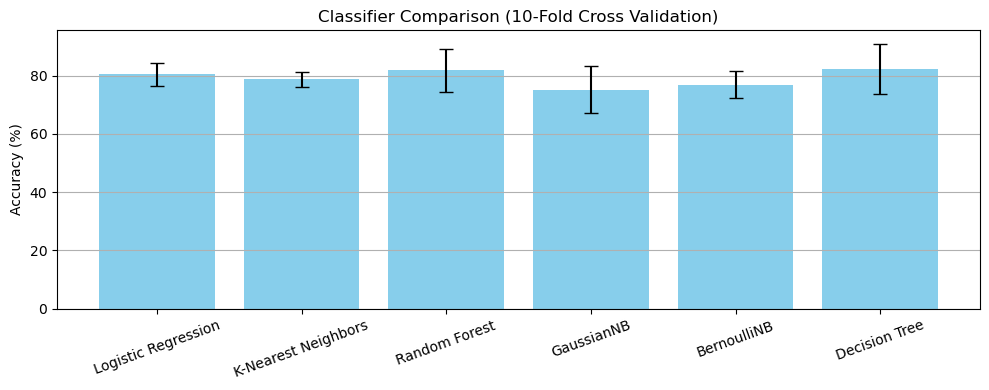

In [142]:
plt.figure(figsize=(10, 4))
plt.bar(results.keys(), results.values(), yerr=std_devs.values(), capsize=5, color='skyblue')
plt.ylabel("Accuracy (%)")
plt.title("Classifier Comparison (10-Fold Cross Validation)")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = len(cm)
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))

In [143]:
#  Print all classifier accuracies
print("\nClassifier Accuracies (10-Fold Cross Validation):")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")


Classifier Accuracies (10-Fold Cross Validation):
Logistic Regression: 80.45%
K-Nearest Neighbors: 78.68%
Random Forest: 81.80%
GaussianNB: 75.14%
BernoulliNB: 76.88%
Decision Tree: 82.25%


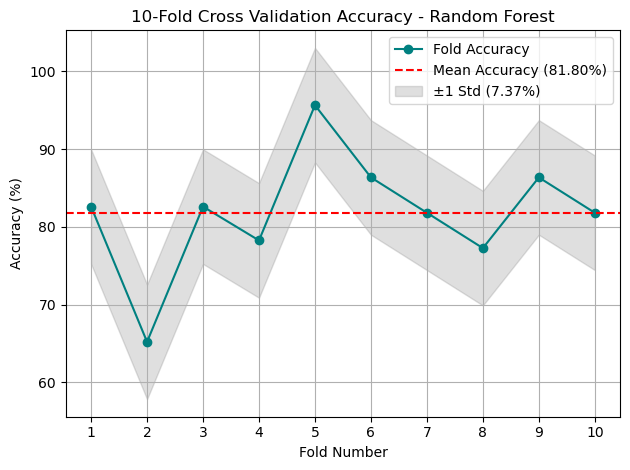

In [144]:
# Pick one classifier for the fold accuracy plot
model_name = "Random Forest"
model = classifiers[model_name]
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)

accuracies = np.array(scores)
accuracy_by_10fold_cv = accuracies.mean() * 100
std = accuracies.std() * 100

# Plot fold accuracies
plt.plot(range(1, 11), accuracies * 100, marker='o', linestyle='-', color='teal', label='Fold Accuracy')
plt.axhline(y=accuracy_by_10fold_cv, color='red', linestyle='--', label=f'Mean Accuracy ({accuracy_by_10fold_cv:.2f}%)')
plt.fill_between(range(1, 11),
                 accuracies * 100 - std,
                 accuracies * 100 + std,
                 color='gray', alpha=0.25, label=f'±1 Std ({std:.2f}%)')

plt.title(f'10-Fold Cross Validation Accuracy - {model_name}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

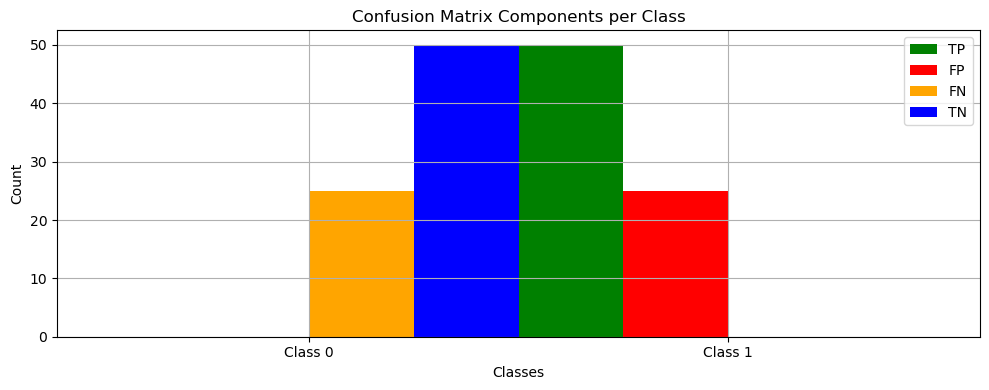

In [145]:
classes = [f'Class {i}' for i in range(num_classes)]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 4))
plt.bar(x - width*1.5, TP, width, label='TP', color='green')
plt.bar(x - width/2, FP, width, label='FP', color='red')
plt.bar(x + width/2, FN, width, label='FN', color='orange')
plt.bar(x + width*1.5, TN, width, label='TN', color='blue')

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Confusion Matrix Components per Class')
plt.xticks(x, classes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


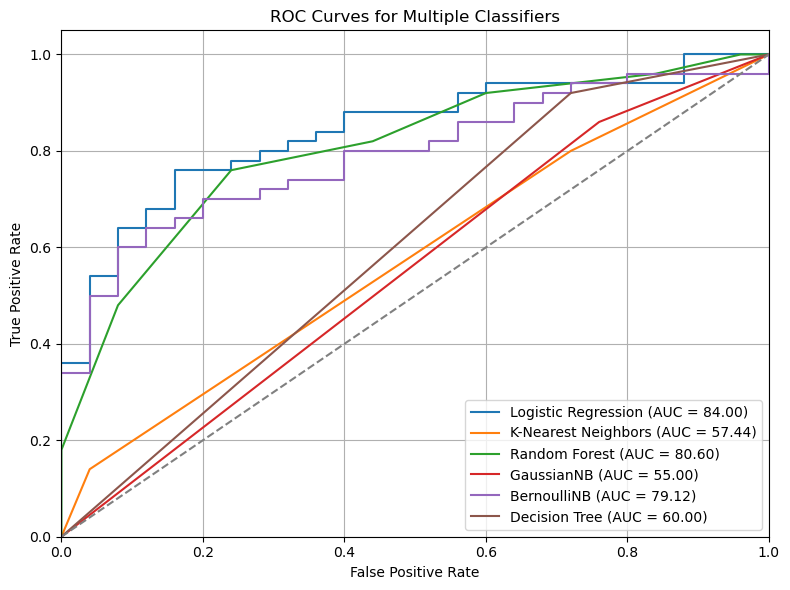

In [146]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

plt.figure(figsize=(8, 6))
accuracies = {}
roc_accuracies = {}

for name, clf in classifiers.items():
    try:
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]  # probability of positive class
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)*100
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc :.2f})")
        roc_accuracies[name] = roc_auc  # ✅ dictionary entry

    except Exception as e:
        print(f"{name} skipped: {e}")
        

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Classifiers')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [147]:
#  Print all classifier accuracies
print("\nClassifier Accuracies on Test Set:")
for name, acc in roc_accuracies.items():
    print(f"{name}: {acc:.2f}%")


Classifier Accuracies on Test Set:
Logistic Regression: 84.00%
K-Nearest Neighbors: 57.44%
Random Forest: 80.60%
GaussianNB: 55.00%
BernoulliNB: 79.12%
Decision Tree: 60.00%


In [148]:

print("\n🔍 Accuracy Comparison:\n")
print(f"{'Classifier':<25}{'Test Accuracy (%)':>20}{'CV Accuracy (%)':>20}")
print("-" * 65)
for name in classifiers:
    test_acc = roc_accuracies.get(name, 0) 
    cv_acc = cv_accuracies.get(name, 0)
    print(f"{name:<25}{test_acc:>20.2f}{cv_acc:>20.2f}")



🔍 Accuracy Comparison:

Classifier                  Test Accuracy (%)     CV Accuracy (%)
-----------------------------------------------------------------
Logistic Regression                     84.00               80.45
K-Nearest Neighbors                     57.44               78.68
Random Forest                           80.60               81.80
GaussianNB                              55.00               75.14
BernoulliNB                             79.12               76.88
Decision Tree                           60.00               82.25


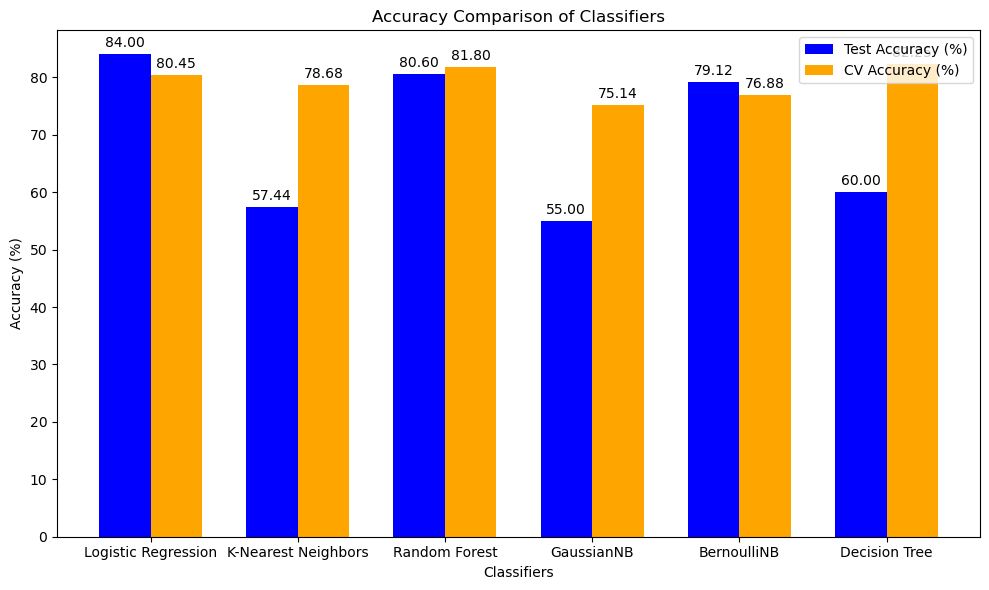

In [149]:
# Prepare data for plotting
labels = classifiers
test_accuracies = [roc_accuracies[name] for name in labels]
cv_accuracies = [cv_accuracies[name] for name in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, test_accuracies, width, label='Test Accuracy (%)', color='blue')
bars2 = ax.bar(x + width/2, cv_accuracies, width, label='CV Accuracy (%)', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison of Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Show the plot
plt.tight_layout()
plt.show()

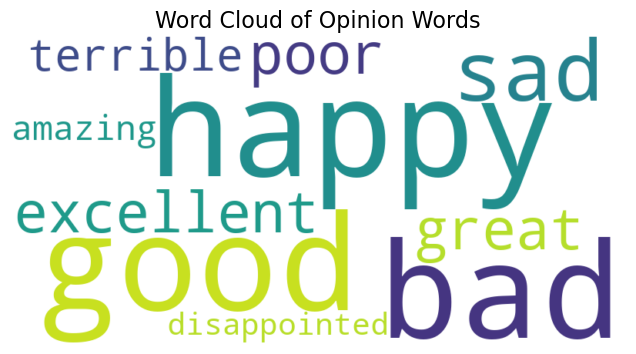

In [150]:


from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming OW_in_corpus is a list of opinion words
OW_in_corpus = ["happy", "good", "bad", "sad", "excellent", "poor", "great", "terrible", "amazing", "disappointed"]

# Convert the list into a string (WordCloud expects a single string)
text = ' '.join(OW_in_corpus)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Opinion Words", fontsize=16)
plt.show()


In [151]:
print('\n\nOpinionWords:\n', OW_in_corpus)



OpinionWords:
 ['happy', 'good', 'bad', 'sad', 'excellent', 'poor', 'great', 'terrible', 'amazing', 'disappointed']
